In [1]:
!pip install face_recognition


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import face_recognition

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import shutil
import face_recognition as fc
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import sklearn.metrics as smt
import seaborn as sns

In [4]:
df = pd.read_csv('face_dataset.csv')
df.head()

,id,label
0,vinay (4).jpg,vinay
1,ravina8.jpg,ravina
2,kishita (10).jpg,kishita
3,ravina34.jpg,ravina
4,kirti (49).jpg,kirti


In [5]:
df.label.value_counts().to_frame()

,count
label,
vinay,110
anima johri,100
kirti,77
nehil,55
mohit,55
aditya,55
abhijay,55
vansh,55
sakshi,51


In [6]:
def encode_images(df):
    dir = 'Original image'
    face_encodings_list = []
    labels_list = []
    for path, label in df.values:
        img_path = os.path.join(dir, label, path)
        image = fc.load_image_file(img_path)
        face_encodings = fc.face_encodings(image)

        if face_encodings:
            face_encoding = face_encodings[0]
            face_encodings_list.append(face_encoding)
            labels_list.append(label)
    return face_encodings_list, labels_list

In [7]:
x, y = encode_images(df)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.15, stratify=y, random_state=42
)

In [9]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', weights='distance')

In [10]:
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance')

In [11]:
knn_clf.score(x_train, y_train)

1.0

In [12]:
y_pred = knn_clf.predict(x_test)
precision = smt.precision_score(y_test, y_pred, average='weighted')
recall = smt.recall_score(y_test, y_pred, average='weighted')
f1 = smt.f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 1.000


<Axes: >

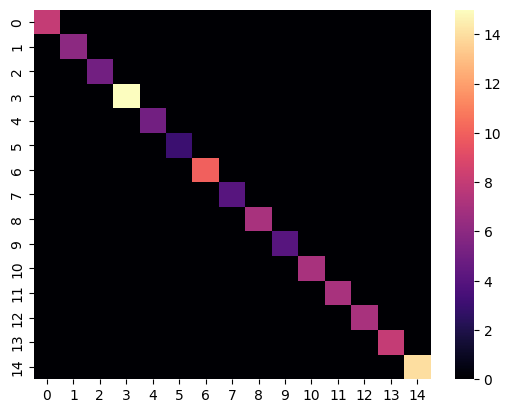

In [14]:
conf_matrix = smt.confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix,cmap='magma')

In [15]:
def show_image(image, x=10, y=8, bgr=False):
    plt.figure(figsize=(x, y))

    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    elif len(image.shape) == 3:
        if bgr:
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        plt.imshow(image)

    plt.xticks([])
    plt.yticks([])
    plt.show()

In [16]:
def predict_and_visualize(image_path):
    # Read the image
    image = cv.imread(image_path)
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_height, image_width = image.shape[:2]

    # Predict
    face_locations = fc.face_locations(rgb_image)
    face_encodings = fc.face_encodings(rgb_image, face_locations)

    # Visualize
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):

        matches = knn_clf.kneighbors([face_encoding], n_neighbors=1)
        name = knn_clf.predict([face_encoding])[0] if matches[0][0][0] < 0.5 else "Unknown"
        cv.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 1)
        font_scale = image_width / 450
        text_position = (left, bottom + int(image_height * 0.06))
        cv.putText(image, name, text_position, cv.FONT_HERSHEY_TRIPLEX, font_scale, (0, 255, 0), 1)

    show_image(image, bgr=True)

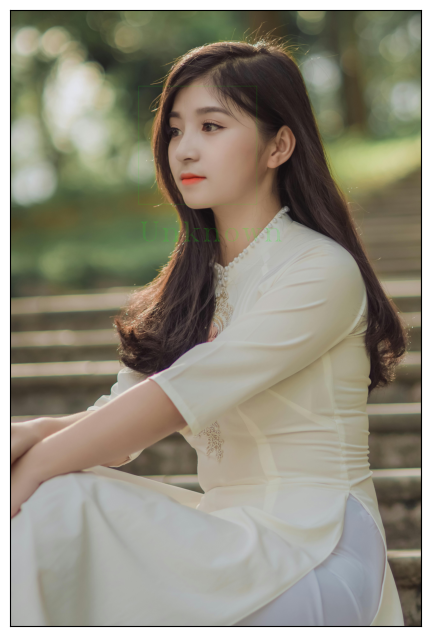

In [17]:
img = 'p.jpg'
predict_and_visualize(img)

In [ ]:
import cv2 as cv
import face_recognition as fc

def live_camera_recognition():
    video_capture = cv.VideoCapture(0)  # Access the webcam

    while True:
        # Capture frame-by-frame
        ret, frame = video_capture.read()
        if not ret:
            break

        rgb_frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        face_locations = fc.face_locations(rgb_frame)
        face_encodings = fc.face_encodings(rgb_frame, face_locations)

        for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
            matches = knn_clf.kneighbors([face_encoding], n_neighbors=1)
            name = knn_clf.predict([face_encoding])[0] if matches[0][0][0] < 0.5 else "Unknown"
            cv.rectangle(frame, (left, top), (right, bottom), (0, 0, 0), 2)
            font_scale = frame.shape[1] / 450
            text_position = (left, bottom + int(frame.shape[0] * 0.06))
            cv.putText(frame, name, text_position, cv.FONT_HERSHEY_TRIPLEX, font_scale, (0, 0, 0), 2)

        # Display the resulting frame
        cv.imshow('Live Face Recognition', frame)

        # Break the loop if 'q' is pressed
        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything is done, release the capture and close windows
    video_capture.release()
    cv.destroyAllWindows()

# Run live camera recognition
live_camera_recognition()